In [35]:
import duckdb as db
import seaborn as sns
import pandas as pd

In [5]:
conn = db.connect()
conn.sql("ATTACH 'dbname=equiv_v2 user=postgres password=herdeherde host=127.0.0.1 port=5430' as pg (TYPE POSTGRES, READ_ONLY)")

In [8]:
conn.sql("""
create or replace table acc as
with acc as (
  select
    t1.name as metric,
    t2.value as model,
    mean as acc,
	step / 365 / 10 as epoch,
    t3.value as rel_pos_bias
  from
    pg.checkpoint_sample_metric_float as t1
    join pg.model_parameter_text as t2 on t1.model_id = t2.model_id
    left join pg.model_parameter_text as t3 on t1.model_id = t3.model_id
    and t3.name = 'train_config.model.config.rel_pos_bias'
  where
    t2.name = 'train_config.model.name'
    --and t3.name = 'train_config.model.config.rel_pos_bias'
)
select
  model,
  metric,
  acc,
  epoch,
  rel_pos_bias
from
  acc
where metric like 'acc_%'
""")

In [9]:
conn.sql("SELECT * from acc where model='SwinHPPangu' and rel_pos_bias='single' and metric like 'acc_surface%' limit 10")

┌─────────────┬────────────────────┬─────────────────────┬────────────────────┬──────────────┐
│    model    │       metric       │         acc         │       epoch        │ rel_pos_bias │
│   varchar   │      varchar       │       double        │       double       │   varchar    │
├─────────────┼────────────────────┼─────────────────────┼────────────────────┼──────────────┤
│ SwinHPPangu │ acc_surface_t2m.3d │   0.809992903718624 │ 110.05479452054794 │ single       │
│ SwinHPPangu │ acc_surface_v10.3d │   0.840645116334077 │ 110.05479452054794 │ single       │
│ SwinHPPangu │ acc_surface_u10.3d │  0.8400454109052863 │ 110.05479452054794 │ single       │
│ SwinHPPangu │ acc_surface_msl.3d │  0.9289881754416093 │ 110.05479452054794 │ single       │
│ SwinHPPangu │ acc_surface_t2m.9d │  0.3842630050012524 │ 110.05479452054794 │ single       │
│ SwinHPPangu │ acc_surface_v10.9d │   0.289398542954088 │ 110.05479452054794 │ single       │
│ SwinHPPangu │ acc_surface_u10.9d │  0.3415144719

In [10]:
conn.sql("""
create or replace table data as
select
  try_cast(
    split_part(split_part(metric, '.', 1), '_', -1) as integer
  ) as pressure,
  try_cast(trim(split_part(metric, '.', 2), 'd') as integer) as days,
  string_split(split_part(metric, '.', 1), '_') [1:3] as metric,  --"min(rmse)" as min_rmse,
  *
from
  acc
where
  (
    model = 'SwinHPPangu'
    and epoch > 101
    and epoch < 111
    and rel_pos_bias='single'
  )
  or (
    model = 'PanguParametrized'
    and epoch > 200
  )
  or (
model = 'Pangu' and epoch > 140)
""")

In [11]:
conn.sql("""
create or replace table uadata as
select
  model,
  metric,
  avg(acc) as acc,
  days
  --rel_pos_bias
from
  data
 where
  pressure > 50
  or pressure is null
group by
  model,
  metric,
  days,
  rel_pos_bias
""")

In [12]:
df = conn.sql("""
select
  days,
  acc,
    CASE model
   WHEN 'SwinHPPangu' THEN 'PEAR'
   WHEN 'PanguParametrized' THEN 'Pangu'
   WHEN 'Pangu' THEN 'PanguLarge'
   ELSE model
   END as model,
  metric :: varchar as metric
from
  uadata
order by
  metric,
  model,
  days
""").df()

In [20]:
df

,days,acc,model,metric
0,1,0.986895,PEAR,"[acc, surface, msl]"
1,2,0.966183,PEAR,"[acc, surface, msl]"
2,3,0.928988,PEAR,"[acc, surface, msl]"
3,4,0.871641,PEAR,"[acc, surface, msl]"
4,5,0.793452,PEAR,"[acc, surface, msl]"
...,...,...,...,...
238,5,0.714418,PanguSmall,"[acc, upper, z]"
239,6,0.624438,PanguSmall,"[acc, upper, z]"
240,7,0.539359,PanguSmall,"[acc, upper, z]"
241,8,0.467284,PanguSmall,"[acc, upper, z]"


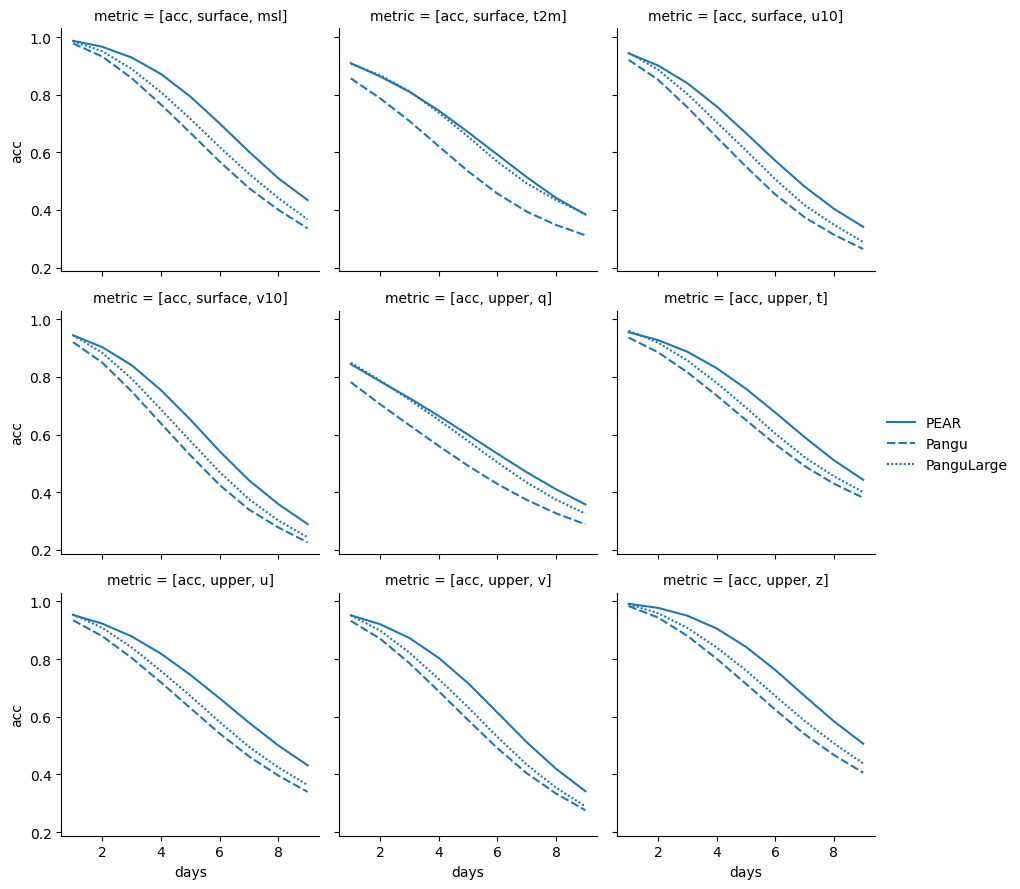

In [13]:
g = sns.FacetGrid(df, col="metric", sharey=True, col_wrap=3)
g.map_dataframe(sns.lineplot, x="days", y="acc", style="model")
g.add_legend()
g.savefig('acc_iterated.pdf')

In [63]:
df_table = df[(df["days"] == 1) | (df["days"] == 3) | (df["days"] == 5)]

In [64]:
df_table

,days,acc,model,metric
0,1,0.986895,PEAR,"[acc, surface, msl]"
2,3,0.928988,PEAR,"[acc, surface, msl]"
4,5,0.793452,PEAR,"[acc, surface, msl]"
9,1,0.977815,Pangu,"[acc, surface, msl]"
11,3,0.857530,Pangu,"[acc, surface, msl]"
...,...,...,...,...
227,3,0.880976,Pangu,"[acc, upper, z]"
229,5,0.714418,Pangu,"[acc, upper, z]"
234,1,0.989794,PanguLarge,"[acc, upper, z]"
236,3,0.908352,PanguLarge,"[acc, upper, z]"


In [29]:
def highlight_max(row):
    m = row.max()
    return ['\\bfseries' if v == m else '' for v in row]

for group_name, group in df_table.groupby("metric"):
    t = group.pivot(index="days", columns="model", values="acc")
    latex = (t.style.highlight_max(axis=1, props='font-weight: bold;')
      .to_latex(hrules=True))

In [30]:
t

model,PEAR,Pangu,PanguLarge
days,,,
1,0.991898,0.983977,0.989794
3,0.950640,0.880976,0.908352
5,0.842537,0.714418,0.760849


In [59]:
df_table["metric"].iloc[0]
      

'[acc, surface, msl]'

In [73]:
# copy so we don’t touch the original
df_table = df[(df["days"] == 1) | (df["days"] == 3) | (df["days"] == 5)]
panel = df_table.copy()

def metric_to_latex(s: str) -> str:
    p = [x.strip() for x in s.strip('[]').split(',')]
    base = '{}' # r'\mathrm{' + p[0].upper() + '}'
    sub  = r'_\mathrm{' + p[1] + '}'  if len(p) > 1 else ''
    sup  = r'^\mathrm{' + p[2] + '}'  if len(p) > 2 else ''
    return f'${base}{sub}{sup}$'

panel['metric'] = panel['metric'].map(metric_to_latex)

tbl = (panel
       .pivot_table(index=['metric', 'days'], columns='model', values='acc')
       .reindex(columns=['PEAR', 'Pangu', 'PanguLarge']))

sty = (tbl.style
           .format('{:.3f}')                     # one decimal
           .highlight_max(axis=1,
                          subset=['PEAR', 'Pangu'],
                          props='font-weight: bold;'))

latex = sty.to_latex(hrules=True,
                     convert_css=True,
                    # escape=False,
                     column_format='l'*tbl.index.nlevels + 'rr|r')  # | before PanguLarge

# add \midrule between metrics
out, first = [], True
for ln in latex.splitlines():
    if ln.lstrip().startswith(r'\multirow'):
        if not first:
            out.append(r'\midrule')
        first = False
    out.append(ln)

print('\n'.join(out))


\begin{tabular}{llrr|r}
\toprule
 & model & PEAR & Pangu & PanguLarge \\
metric & days &  &  &  \\
\midrule
\multirow[c]{3}{*}{${}_\mathrm{surface}^\mathrm{msl}$} & 1 & \bfseries 0.987 & 0.978 & 0.986 \\
 & 3 & \bfseries 0.929 & 0.858 & 0.889 \\
 & 5 & \bfseries 0.793 & 0.668 & 0.716 \\
\midrule
\multirow[c]{3}{*}{${}_\mathrm{surface}^\mathrm{t2m}$} & 1 & \bfseries 0.909 & 0.857 & 0.907 \\
 & 3 & \bfseries 0.810 & 0.709 & 0.812 \\
 & 5 & \bfseries 0.670 & 0.534 & 0.654 \\
\midrule
\multirow[c]{3}{*}{${}_\mathrm{surface}^\mathrm{u10}$} & 1 & \bfseries 0.943 & 0.921 & 0.946 \\
 & 3 & \bfseries 0.840 & 0.757 & 0.803 \\
 & 5 & \bfseries 0.667 & 0.551 & 0.607 \\
\midrule
\multirow[c]{3}{*}{${}_\mathrm{surface}^\mathrm{v10}$} & 1 & \bfseries 0.944 & 0.921 & 0.945 \\
 & 3 & \bfseries 0.841 & 0.750 & 0.794 \\
 & 5 & \bfseries 0.652 & 0.528 & 0.578 \\
\midrule
\multirow[c]{3}{*}{${}_\mathrm{upper}^\mathrm{q}$} & 1 & \bfseries 0.844 & 0.782 & 0.849 \\
 & 3 & \bfseries 0.726 & 0.632 & 0.721 \\
 &

In [56]:
print(latex)

\begin{tabular}{llrr|r}
\toprule
 & model & PEAR & Pangu & PanguLarge \\
metric & days &  &  &  \\
\midrule
\multirow[c]{3}{*}{[acc, surface, msl]} & 1 & \bfseries 0.986895 & 0.977815 & 0.985527 \\
 & 3 & \bfseries 0.928988 & 0.857530 & 0.889305 \\
 & 5 & \bfseries 0.793452 & 0.667695 & 0.716488 \\
\multirow[c]{3}{*}{[acc, surface, t2m]} & 1 & \bfseries 0.909464 & 0.856668 & 0.906742 \\
 & 3 & \bfseries 0.809993 & 0.708598 & 0.811780 \\
 & 5 & \bfseries 0.669952 & 0.534233 & 0.654259 \\
\multirow[c]{3}{*}{[acc, surface, u10]} & 1 & \bfseries 0.943139 & 0.920939 & 0.945537 \\
 & 3 & \bfseries 0.840045 & 0.756692 & 0.802733 \\
 & 5 & \bfseries 0.666791 & 0.550886 & 0.606867 \\
\multirow[c]{3}{*}{[acc, surface, v10]} & 1 & \bfseries 0.944371 & 0.920640 & 0.944537 \\
 & 3 & \bfseries 0.840645 & 0.749995 & 0.794048 \\
 & 5 & \bfseries 0.651919 & 0.528282 & 0.577973 \\
\multirow[c]{3}{*}{[acc, upper, q]} & 1 & \bfseries 0.843914 & 0.781973 & 0.849419 \\
 & 3 & \bfseries 0.726374 & 0.632091 &